# Use Cases

MLRun serving graphs allow to easily build real-time data processing and
advanced model serving pipelines, and deploy them quickly to production with
minimal effort.

Capabilities:

- Easily build and manage complex inference graphs with multiple models
- Real-time serverless engine for optimized utilization (auto scale up/down)
- Support advanced applications including streaming, machine learning, deep-learning, NLP
- Debug in the IDE/Notebook, deploy to production using a single command

<br>

![serving graph high level](../../_static/images/serving-graph-high-level.png)

> **Note**
> 
> The feature store uses the serving graph as an underlying technology. Therefore, you will find many similarities
> in the examples here and the feature store examples.


## Serving Functions

To start using a serving graph, you first need a serving function. A serving function contains the serving
class code to run the model and all the code necessary to run the tasks. MLRun comes with a wide library of tasks, if you
use just those, you don't have to add any special code to the serving function, you just have to provide
the code that runs the model. For more information about serving classes see the [serving class overview](./serving-class-overview.md)

For example, the following code is a basic model serving class:

In [1]:
# mlrun: start-code

In [2]:
from cloudpickle import load
from typing import List
import numpy as np

import mlrun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [3]:
# mlrun: end-code

To obtain the serving function, we use `code_to_function` and specify `kind` to be `serving`.

In [4]:
fn = mlrun.code_to_function("serving_example",
                            kind="serving", 
                            image="mlrun/mlrun")

For more information, refer to the [model serving documentation](./serving-class-overview.md).

## Topology

### Router
Once you have a serving function, you need to choose the graph topology. The default is `router` topology which allows you to
specify different machine learning models. Each model has a logical name. This name is used to route to the correct model when calling the serving function.

In [5]:
from sklearn.datasets import load_iris

# set the topology/router and add models
graph = fn.set_topology("router")

# Add the model
fn.add_model("model1", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

# Add additional models
#fn.add_model("model2", class_name="ClassifierModel", model_path="<path2>")

# create and use the graph simulator
server = fn.to_mock_server()
x = load_iris()['data'].tolist()
result = server.test("/v2/models/model1/infer", {"inputs": x})

print(result)

> 2021-11-02 04:18:36,925 [info] model model1 was loaded
> 2021-11-02 04:18:36,926 [info] Initializing endpoint records
> 2021-11-02 04:18:36,965 [info] Loaded ['model1']
{'id': '6bd11e864805484ea888f58e478d1f91', 'model_name': 'model1', 'outputs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}


### Flow

Using the `flow` topology, you can specify tasks that typically manipulate the data. The most common scenario is pre-processing of the data
prior to the model execution

> **Note:**: Once the topology is set, you cannot change an existing function toplogy.

In this topology, you build and connect the graph (DAG) by adding steps using the `step.to()` method, or by using the 
`graph.add_step()` method.

> The `step.to()` is typically used to chain steps together. `graph.add_step` can add steps anywhere on the
> graph and has `before` and `after` parameters to specify the location of the step.

<<< show example without router >>>

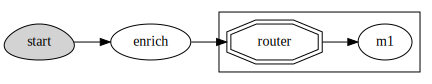

In [18]:
fn2 = mlrun.code_to_function("serving_example_flow",
                             kind="serving", 
                             image="mlrun/mlrun")

graph2 = fn2.set_topology("flow")     

graph2_enrich = graph2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')

# add an Ensemble router with two child models (routes), the "*" prefix mark it is a router class
router = graph2.add_step(mlrun.serving.ModelRouter(), name="router", after="enrich")
router.add_route("m1", class_name="ClassifierModel", model_path='https://s3.wasabisys.com/iguazio/models/iris/model.pkl')
router.respond()

# Add additional models
#router.add_route("m2", class_name="ClassifierModel", model_path=path2)

# plot the graph (using Graphviz)
graph2.plot(rankdir='LR')

In [7]:
fn2_server = fn2.to_mock_server()

result = fn2_server.test("/v2/models/m1/infer", {"inputs": x})

print(result)

> 2021-11-02 04:18:42,142 [info] model m1 was loaded
> 2021-11-02 04:18:42,142 [info] Initializing endpoint records
> 2021-11-02 04:18:42,183 [info] Loaded ['m1']
{'id': 'f713fd7eedeb431eba101b13c53a15b5'}


## Remote

It is possible to chain functions together with remote execution. This allows you:

- Call existing functions from the graph and reuse them from other graphs.
- Scale up and down different components individually

Calling a remote function can either use HTTP or via a queue (streaming)

### HTTP

Calling a function using http uses the special `$remote` class. We first deploy the function:

In [8]:
remote_func_name = "serving-example-flow"
project_name = "graph-basic-concepts"
fn_remote = mlrun.code_to_function(remote_func_name,
                                   project=project_name,
                                   kind="serving", 
                                   image="mlrun/mlrun")

fn_remote.add_model("model1", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

remote_addr = fn_remote.deploy()

> 2021-11-02 04:18:47,490 [info] Starting remote function deploy
2021-11-02 04:18:47  (info) Deploying function
2021-11-02 04:18:47  (info) Building
2021-11-02 04:18:47  (info) Staging files and preparing base images
2021-11-02 04:18:47  (info) Building processor image
2021-11-02 04:18:49  (info) Build complete
2021-11-02 04:18:55  (info) Function deploy complete
> 2021-11-02 04:18:55,403 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-graph-basic-concepts-serving-example-flow.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['graph-basic-concepts-serving-example-flow-graph-basic-concepts.default-tenant.app.aganefaibuzg.iguazio-cd2.com/']}


Create a new function with a graph and call the remote function:

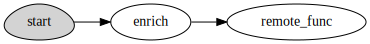

In [9]:
fn_preprocess = mlrun.new_function("preprocess", kind="serving")
graph_preprocessing = fn_preprocess.set_topology("flow")

graph_preprocessing.to("storey.Extend", name="enrich", _fn='({"tag": "something"})').to(
                       "$remote", "remote_func", url=f'{remote_addr}v2/models/model1/infer', method='put').respond()

graph_preprocessing.plot(rankdir='LR')

In [10]:
fn3_server = fn_preprocess.to_mock_server()

result = fn3_server.test("", {"inputs": x})

print(result)

{'id': '5af0c66f-e6f1-4837-813a-f2db27bf33cd', 'model_name': 'model1', 'outputs': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}


### Queue (streaming)

Using queues it is possible to send events from one part of the graph to another and decouple the processing of those parts.
Queues are better suited to deal with burst of events, since all the events are stored in the queue until they are processed.
In the example below we use V3IO stream which is a fast real-time implementation of a stream that allows processing of events at very low latency.

In [11]:
%%writefile echo.py
def echo_handler(x):
    print(x)
    return x

Overwriting echo.py


Configure the streams

In [12]:
import os
streams_prefix = f"v3io:///users/{os.getenv('V3IO_USERNAME')}/examples/graph-basic-concepts"

input_stream = streams_prefix + "/in-stream"
out_stream = streams_prefix + "/out-stream"
err_stream = streams_prefix + "/err-stream"

Create the graph, note that in the `to` method we specify the class name to be `>>` or `$queue` to specify this is a queue

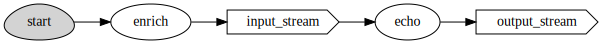

In [13]:
fn_preprocess2 = mlrun.new_function("preprocess", kind="serving")
fn_preprocess2.add_child_function('echo_func', './echo.py', 'mlrun/mlrun')

graph_preprocess2 = fn_preprocess2.set_topology("flow")

graph_preprocess2.to("storey.Extend", name="enrich", _fn='({"tag": "something"})')\
                 .to(">>", "input_stream", path=input_stream)\
                 .to(name="echo", handler="echo_handler", function="echo_func")\
                 .to(">>", "output_stream", path=out_stream)

graph_preprocess2.plot(rankdir='LR')

In [14]:
fn4_server = fn_preprocess2.to_mock_server(current_function="*")

result = fn4_server.test("", {"inputs": x})

print(result)

ImportError: state init failed, function echo_handler not found, Empty module name

## Engine

TBD do we need this?